#  Speech Processing 
## 分為使用librosa套件的做法(驗證用)和自定義function的做法

In [483]:
import wave
import matplotlib.pyplot as plt
import numpy
import math
import librosa
import librosa.display
import IPython.display
import pylab as pl
import pyaudio
IPython.display.Audio('voice.wav')

## 使用librosa套件，讀取wav檔及變數設定

In [484]:
voice, fs = librosa.load('voice.wav') #audio time series(np.ndarray),sampling rate

In [485]:
fs #sampling rate 預設

22050

In [486]:
len(voice)

84672

In [487]:
time=len(voice)/fs #秒數
time

3.84

In [488]:
#確認秒數算法正確
librosa.core.get_duration(voice)

3.84

In [489]:
frame_len = int(30 * fs /1000) 
frame_shift = int(10 * fs /1000)

## 自訂function部分，讀取wav檔及變數設定

In [490]:
f=wave.open("voice.wav","rb")
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
str_data = f.readframes(nframes)#按照採樣點讀取數據
# 轉成數組形式
wave_data = numpy.frombuffer(str_data, dtype = numpy.short)
#wave_data.shape = -1, 1
frameSize = 256
f.close()

In [491]:
len(wave_data) #採樣點數目

338688

In [492]:
framerate 

44100

In [493]:
nframes

169344

# (1).Waveform


## 法1.librosa.display.waveplot

#### Plot the amplitude envelope of a waveform

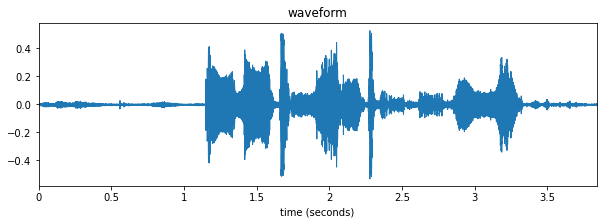

In [494]:
plt.figure(figsize=(10, 3))
librosa.display.waveplot(voice, sr=fs)
plt.xlabel("time (seconds)")
plt.title('waveform')
plt.show()

## 法2.描點

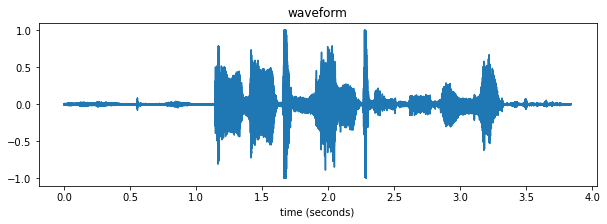

In [495]:
wave_norm = wave_data / (abs(wave_data)).max()
plt.figure(figsize=(10, 3))
t = numpy.linspace(0, time, len(wave_norm))
plt.plot(t, wave_norm)
plt.xlabel("time (seconds)")
plt.title('waveform')
plt.show()

### 比較

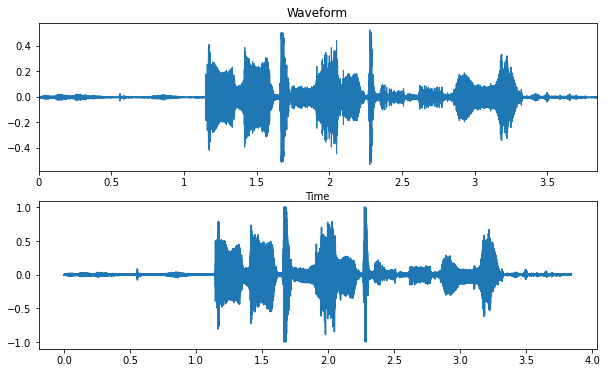

In [496]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.waveplot(voice, sr=fs)
plt.title('Waveform')
plt.subplot(2, 1, 2)
plt.plot(t, wave_norm)
plt.show()

形狀相同

# (2).Energy contour

## 法1.librosa.feature.rmse

#### Compute root-mean-square (RMS) energy for each frame

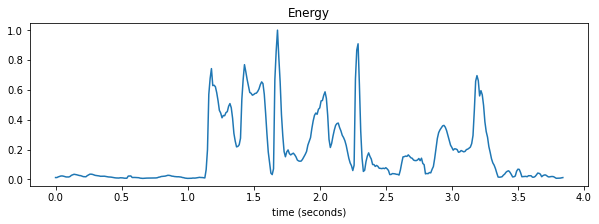

In [497]:
rms = librosa.feature.rms(voice, frame_length=frame_len, hop_length=frame_shift)
rms = rms[0]
rms = librosa.util.normalize(rms, axis=0) #Normalize an array along a chosen axis.

plt.figure(figsize=(10, 3))
te = numpy.linspace(0, time, len(rms))
plt.plot(te,rms, label='Energy contour')
plt.xlabel("time (seconds)")
plt.title('Energy')
plt.show()

## 法2.Function

#### S.E=sum([x(m)^2]*[w(n−m)^2])
#### 其中窗口函數w(n)在此看做1 (方窗)
-> E(n)=sum(x(m))^2 每一幀中所有信號的平方相加

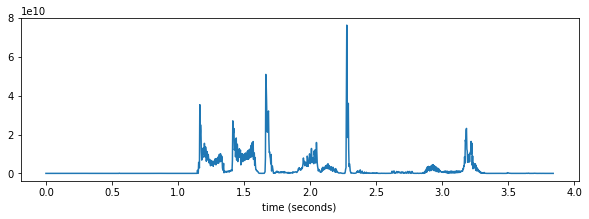

In [498]:
normalenergy=[]

def calEnergy(data) :
    energy = []
    sum = 0
    for i in range(len(data)) :
        sum = sum + (int(data[i]) * int(data[i]))
        if (i + 1) % frameSize == 0 :
            energy.append(sum)
            sum = 0
        elif i == len(data) - 1 :
            energy.append(sum)
    return energy

energy = calEnergy(wave_data)
timee =numpy.linspace(0, time, len(energy))
plt.figure(figsize=(10, 3))
plt.plot(timee, energy)
plt.xlabel("time (seconds)")
plt.show()

#### 為方便觀察正規化to 0-1 range後畫出

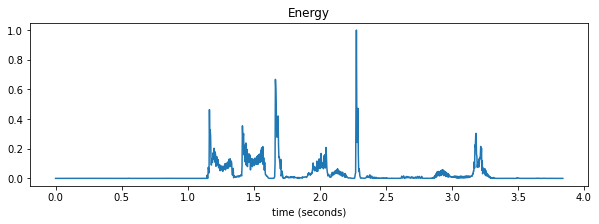

In [499]:
normalenergy=[]
min_energy=min(energy)
max_energy=max(energy)
for i in range(len(energy)):
    norm=(energy[i]-min_energy)/(max_energy-min_energy)
    normalenergy.append(norm)

timee =numpy.linspace(0, time, len(normalenergy))
plt.figure(figsize=(10, 3))
plt.plot(timee, normalenergy)
plt.title('Energy')
plt.xlabel("time (seconds)")
plt.show()

### 比較

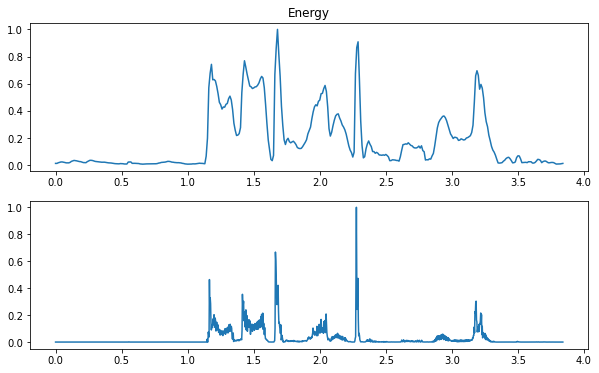

In [500]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.title('Energy')
plt.plot(te,rms, label='Energy contour')
plt.subplot(2, 1, 2)
plt.plot(timee,normalenergy)
plt.show()

形狀大致相似，  
* 法1計算平方平均數，對y=0軸正規化  
* 法2正規化to 0-1 range

# (3).Zero-crossing rate contour
## 法1.librosa.feature.zero_crossing_rate
#### Compute the zero-crossing rate of an audio time series.

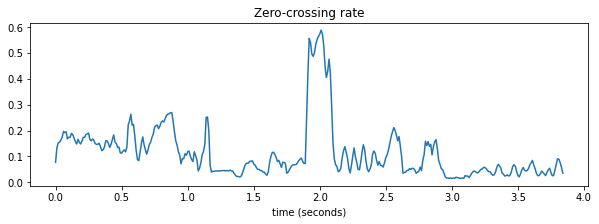

In [501]:
zrc = librosa.feature.zero_crossing_rate(voice, frame_length=frame_len, hop_length=frame_shift, threshold=0)
zrc = zrc[0]
plt.figure(figsize=(10, 3))
tz = numpy.linspace(0, time, len(zrc))
plt.plot(tz,zrc)
plt.xlabel("time (seconds)")
plt.title('Zero-crossing rate')
plt.show()

## 法2.Function
#### 計算每一幀的Zero-crossing rate 256個採樣點爲一幀
####  最後畫圖時再把zcr_cal結果/256 即為Zero-crossing rate

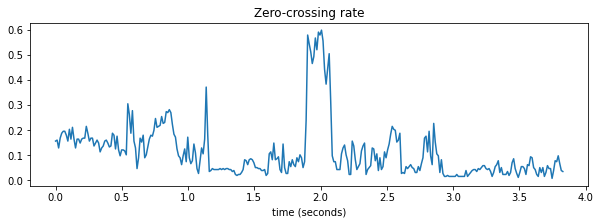

In [502]:
def zcr_cal(waveData,frameSize):
    wlen = len(waveData)
    step = frameSize
    frameNum = math.ceil(wlen/step)
    zcr = numpy.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = waveData[numpy.arange(i*step,min(i*step+frameSize,wlen))]
        zcr[i] = sum(curFrame[0:-1]*curFrame[1::]<=0)
    return zcr

zcr = zcr_cal(voice,frameSize)
timez = numpy.arange(0, len(zcr)) * (len(voice)/len(zcr) / fs)

plt.figure(figsize=(10, 3))
plt.plot(timez, zcr/256)
plt.xlabel("time (seconds)")
plt.title('Zero-crossing rate')
plt.show()

### 比較

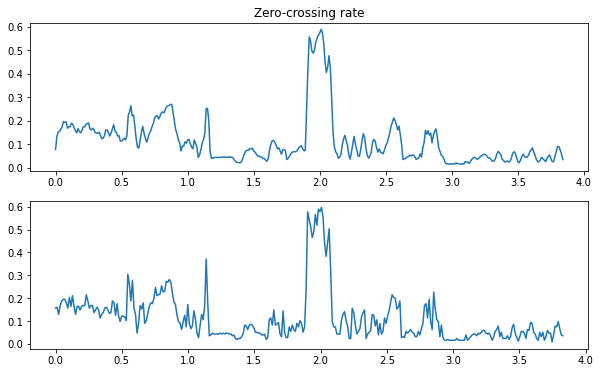

In [503]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.title('Zero-crossing rate')
plt.plot(tz,zrc)
plt.subplot(2, 1, 2)
plt.plot(timez, zcr/256)
plt.show()

兩者形狀已經非常接近，framerate相差2倍

# (4).End point detection

# 閾值

In [504]:
energyAverage=0
for en in rms :
    energyAverage = energyAverage + en
energyAverage = energyAverage / len(rms)
first_en = 0
for en in rms[:10] :
    first_en = first_en + en
first_zcr = 0
for zcr in zrc[:10] :
    first_zcr = float(first_zcr) + zcr      

In [505]:
# 高能量閾
ITH = energyAverage
# 低能量閾
ITU = (first_en/2+energyAverage)/5
# 過零率閾
Zs = first_zcr/10
IZCT=Zs*3
print(ITH,ITU,IZCT)

0.17969826861200008 0.05428705629130657 0.4819969742813919


# 高能量閾搜尋

In [506]:
position=[]
flag = 0
for i in range(len(rms)):
    if len(position) == 0 and flag == 0 and rms[i] > ITH :
        position.append(i)
        flag = 1
    elif flag == 0 and rms[i] > ITH and i - 11 > position[len(position) - 1]:
        position.append(i)
        flag = 1
    elif flag == 0 and rms[i] > ITH and i - 11 <= position[len(position) - 1]:
        position = position[:len(position) - 1]
        flag = 1
    if flag == 1 and rms[i] < ITH :
        position.append(i)
        flag = 0
#print(str(position))

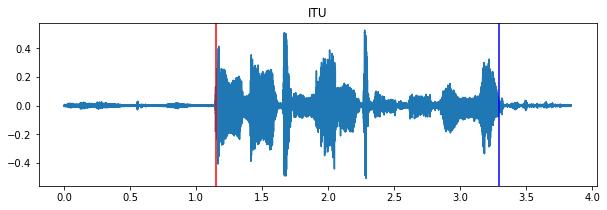

In [507]:
plt.figure(figsize=(10, 3))
t = numpy.linspace(0, time, len(voice))
plt.plot(t, voice, label='Waveform')
plt.title("ITU")
plt.axvline(x=position[0]* frame_shift / fs, color='r') 
plt.axvline(x=position[-1]* frame_shift / fs, color='b')
plt.show()

# 向兩端進行搜尋，將較低能量段的語音部分也加入到語音段

In [508]:
startp=position[0]
endp=position[-1]
position = []
while startp > 0 and rms[startp] > ITU :
    startp = startp - 1
position.append(startp)
while endp < len(rms) and rms[endp] > ITU :
    endp = endp + 1
position.append(endp)
#print(str(position))

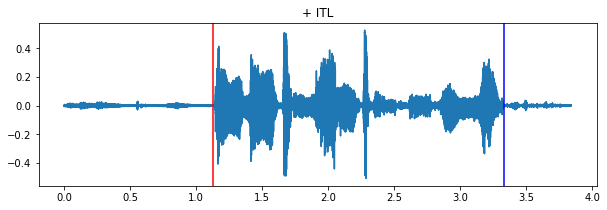

In [509]:
plt.figure(figsize=(10, 3))
t = numpy.linspace(0, time, len(voice))
plt.plot(t, voice, label='Waveform')
plt.title("+ ITL")
plt.axvline(x=position[0]* frame_shift / fs, color='r') 
plt.axvline(x=position[-1]* frame_shift / fs, color='b')
plt.show()

# 利用過0率繼續向兩端進行搜尋(語音的清音部分)

In [510]:
startp=position[0]
endp=position[-1]
position = []
while startp > 0 and zrc[startp] > IZCT :
    startp = startp - 1
position.append(startp)
while endp < len(zrc) and zrc[endp] > IZCT :
    endp = endp + 1
position.append(endp)
#print(str(position))

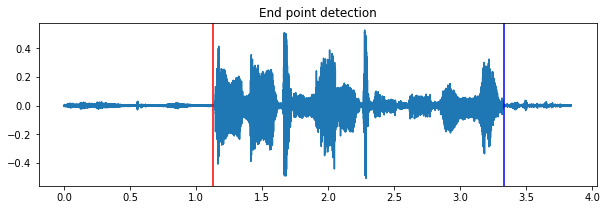

In [511]:
plt.figure(figsize=(10, 3))
t = numpy.linspace(0, time, len(voice))
plt.plot(t, voice, label='Waveform')
plt.title("End point detection")
plt.axvline(x=position[0]* frame_shift / fs, color='r') 
plt.axvline(x=position[-1]* frame_shift / fs, color='b')
plt.show()

# (5).Pitch Contour
### librosa.core.piptrack 
#### returns two 2D arrays with frequency and time axes

"pitches" array gives the interpolated frequency estimate of a particular harmonic 

"magnitudes" array gives the energy of the peak  

Values are zero indicating that there was no local maximum in the spectrum at that time-frequency cell.

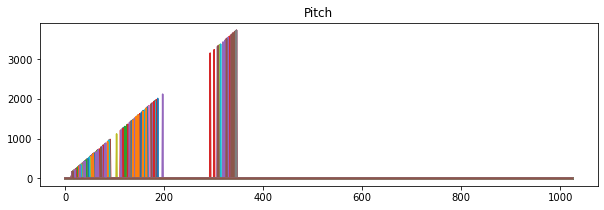

In [512]:
pitches, magnitudes = librosa.core.piptrack(voice, sr=fs,threshold=0.5)
plt.figure(figsize=(10, 3))
plt.plot(pitches)
plt.title("Pitch")
plt.show()

In [513]:
pitches.shape

(1025, 166)

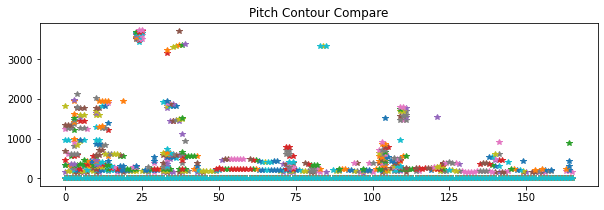

In [514]:
plt.figure(figsize=(10, 3))
plt.plot(numpy.tile(numpy.arange(pitches.shape[1]), [400, 1]).T, pitches[:400, :].T, '*')
plt.title("Pitch Contour Compare")
plt.show()

## 頻率
(音高=>聲音頻率的高低)

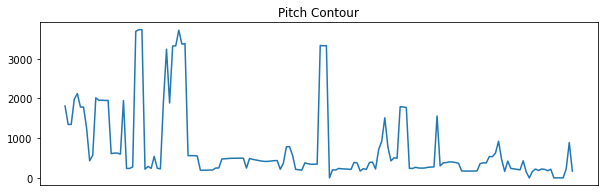

In [515]:
def maxfq(pitches,shape):
    pitch = []
    for i in range(0, shape[1]):
        pitch.append(numpy.max(pitches[:,i]))
    return (pitch)

pitch = maxfq(pitches, pitches.shape)
plt.figure(figsize=(10, 3))
plt.plot(pitch)
plt.xticks([])
plt.title("Pitch Contour")
plt.show()